In [ ]:
#!pip -q uninstall -y diffusers transformers huggingface_hub
#!pip -q install -U "huggingface_hub" "transformers" "diffusers"


In [ ]:
#!pip -q install torchmetrics
#!pip -q install torch-fidelity



In [38]:
from diffusers import DDPMPipeline
from torchvision import datasets, transforms
import random, numpy as np, torch
import torch.nn as nn
import matplotlib.pyplot as plt
import copy

seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [39]:
# ----------------------------
# Load pretrained DDPM (CIFAR10)
# ----------------------------
pipe = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32").to(device)
pipe.set_progress_bar_config(disable=True)
unet = pipe.unet.eval()

for p in unet.parameters():
    p.requires_grad_(False)

alphas_cumprod = pipe.scheduler.alphas_cumprod.to(device)  # shape [T]
T = alphas_cumprod.shape[0]

# DDPM marginal: x_t = sqrt(a_bar_t) x0 + sqrt(1-a_bar_t) eps
def add_ddpm_noise(x0, t, eps=None):
    """
    x0: (B,3,32,32) in [-1,1]
    t:  int timestep in [0, T-1]
    """
    if eps is None:
        eps = torch.randn_like(x0)
    a_bar = alphas_cumprod[t]
    mean_coeff = torch.sqrt(a_bar)
    sigma_t = torch.sqrt(1.0 - a_bar)   # <-- DDPM noise std
    x_t = mean_coeff * x0 + sigma_t * eps
    return x_t, sigma_t

def score_fn_xt(x_t, t, sigma_t=None, with_grad=False):
    if sigma_t is None:
        sigma_t = torch.sqrt(1.0 - alphas_cumprod[t])

    t_tensor = torch.full((x_t.shape[0],), int(t), device=x_t.device, dtype=torch.long)

    if with_grad:
        eps_pred = unet(x_t, t_tensor).sample          # grad flows to x_t
    else:
        with torch.no_grad():
            eps_pred = unet(x_t, t_tensor).sample

    return -(eps_pred / sigma_t)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [40]:
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda z: z*2-1),
])
cifar = datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
loader = torch.utils.data.DataLoader(cifar, batch_size=64, shuffle=True, num_workers=2)


In [41]:
@torch.no_grad()
def select_renyi_landmarks_torch(X, m, sigma2=0.5):
    # X: (n,3,32,32)
    n = X.shape[0]
    m = min(m, n)
    Xf = X.view(n, -1)

    # squared distances (n,n)
    dist2 = torch.cdist(Xf, Xf, p=2.0) ** 2
    K = torch.exp(-dist2 / (2.0 * sigma2))
    diag = torch.diagonal(K)

    row_sums = K.sum(dim=1)
    first = torch.argmin(row_sums).item()

    selected = [first]
    cross_sums = K[:, first].clone()

    while len(selected) < m:
        scores = 2 * cross_sums + diag
        scores[selected] = float("inf")
        nxt = torch.argmin(scores).item()
        selected.append(nxt)
        cross_sums += K[:, nxt]

    return torch.tensor(selected, device=X.device, dtype=torch.long)


In [42]:
import torch

@torch.no_grad()
def estimate_sigma2_median_heuristic(X_t, num_pairs=512, eps=1e-6):
    """
    Fast median heuristic for RBF bandwidth on flattened X_t.
    Returns sigma2 (variance) used in exp(-||x-y||^2 / (2*sigma2)).
    """
    B = X_t.shape[0]
    Xf = X_t.view(B, -1)

    # sample random pairs (i,j)
    i = torch.randint(0, B, (num_pairs,), device=X_t.device)
    j = torch.randint(0, B, (num_pairs,), device=X_t.device)

    diff = Xf[i] - Xf[j]
    dist2 = (diff * diff).sum(dim=1)

    med = torch.median(dist2)
    sigma2 = 0.5 * med + eps  # common choice: sigma^2 = median/2
    return float(sigma2.item())


In [43]:
class RenyiNystroemKSDTorch:

    def __init__(self, sigma2=1.0, m_fn=lambda n: int(4*np.sqrt(n)), ridge=1e-3, mc_eps=4):
        self.sigma2 = float(sigma2)
        self.m_fn = m_fn
        self.ridge = float(ridge)
        self.mc_eps = int(mc_eps)

    def h_p(self, X, Y, t, sigma_t, sigma2, with_grad_score= False):
        X_flat = X.view(X.shape[0], -1)
        Y_flat = Y.view(Y.shape[0], -1)

        grad_logpX = score_fn_xt(X, t, sigma_t, with_grad=with_grad_score).view(X.shape[0], -1)
        grad_logpY = score_fn_xt(Y, t, sigma_t, with_grad=with_grad_score).view(Y.shape[0], -1)

        diff = X_flat[:, None, :] - Y_flat[None, :, :]
        dist2 = (diff**2).sum(dim=2)
        K = torch.exp(-dist2 / (2 * sigma2))

        gram_glogp = grad_logpX @ grad_logpY.T
        gradX = -(diff / sigma2) * K[:, :, None]
        gradY = -gradX

        B = (gradX * grad_logpY[None, :, :]).sum(dim=2)
        C = (gradY * grad_logpX[:, None, :]).sum(dim=2)

        d = X_flat.shape[1]
        gradXY_sum = (dist2 / (sigma2**2) - d / sigma2) * K

        return K * gram_glogp + B + C + gradXY_sum

    def _single_stat_from_xt(self, X_t, t, sigma_t, ridge, sigma2, with_grad_score= False):
        n = X_t.shape[0]
        m = min(self.m_fn(n), n)
        idx = select_renyi_landmarks_torch(X_t, m, sigma2=sigma2)

        H_mn = self.h_p(X_t[idx], X_t, t=t, sigma_t=sigma_t, sigma2=sigma2, with_grad_score=with_grad_score)
        H_mm = H_mn[:, idx]

        H_mm = 0.5 * (H_mm + H_mm.T)
        I = torch.eye(m, device=X_t.device, dtype=H_mm.dtype)
        H_mm_reg = H_mm + ridge * I

        beta = H_mn @ (torch.ones(n, 1, device=X_t.device, dtype=H_mn.dtype) / n)
        x = torch.linalg.solve(H_mm_reg, beta)
        stat = (beta.T @ x).squeeze()
        return stat

    def compute_stat_from_xt(self, X_t, t, sigma_t, ridge=None, sigma2=None, with_grad_score= False):
        if ridge is None: ridge = self.ridge
        if sigma2 is None: sigma2 = self.sigma2
        return self._single_stat_from_xt(
            X_t, t=int(t), sigma_t=sigma_t,
            ridge=float(ridge), sigma2=float(sigma2),
            with_grad_score=with_grad_score
        )

    def compute_stat(self, X0, t, mc_samples=None, ridge=None, sigma2=None, bw_mode="fixed"):
        if mc_samples is None:
            mc_samples = self.mc_eps
        if ridge is None:
            ridge = self.ridge

        stats = []
        for _ in range(int(mc_samples)):
            X_t, sigma_t = add_ddpm_noise(X0, t)

            if bw_mode == "fixed":
                sigma2_eff = self.sigma2 if sigma2 is None else float(sigma2)
            elif bw_mode == "median":
                sigma2_eff = estimate_sigma2_median_heuristic(X_t)
            else:
                raise ValueError("bw_mode must be 'fixed' or 'median'")

            stats.append(self._single_stat_from_xt(
                X_t, t=t, sigma_t=sigma_t,
                ridge=float(ridge), sigma2=sigma2_eff,
                with_grad_score=False   # <-- IMPORTANT default for eval/baseline
            ))

        return torch.stack(stats).mean()


ksd = RenyiNystroemKSDTorch(sigma2=1.0, ridge=1e-3, mc_eps=4)


In [44]:
class DCGANGen(nn.Module):
    def __init__(self, z_dim=128, ngf=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf), nn.ReLU(True),

            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.net(z)

G = DCGANGen(z_dim=128).to(device)
opt = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))


In [45]:
def estimate_real_baseline(t, num_batches=5, mc_samples=4, ridge=1e-3):
    vals = []
    it = iter(loader)
    for _ in range(num_batches):
        xr, _ = next(it)
        xr = xr.to(device)
        vals.append(ksd.compute_stat(xr, t=t, mc_samples=mc_samples, ridge=ridge).item())
    return float(np.mean(vals)), float(np.std(vals))

# Choose an initial diffusion level (not too small at first)
# (You can later anneal it downward.)
t_baseline = int(0.6 * (T - 1))
real_mean, real_std = estimate_real_baseline(t_baseline, num_batches=5)
print(f"KSD(real @ t={t_baseline}) baseline: mean={real_mean:.2f}, std={real_std:.2f}")

KSD(real @ t=599) baseline: mean=0.54, std=0.07


In [46]:
@torch.no_grad()
def quick_eval(G, loader, ksd, t_list, batch_size=64, z_dim=128):
    # real baseline (1 batch each t)
    it = iter(loader)
    real0, _ = next(it)
    real0 = real0.to(device)

    real_vals = []
    fake_vals = []

    z = torch.randn(batch_size, z_dim, 1, 1, device=device)
    fake0 = G(z)

    for t in t_list:
        # same t for both
        real_t, sigma_t_r = add_ddpm_noise(real0, t)
        fake_t, sigma_t_f = add_ddpm_noise(fake0, t)

        # bandwidth from combined cloud (cheap + stable)
        Xt = torch.cat([real_t, fake_t], dim=0)
        sigma2_eff = estimate_sigma2_median_heuristic(Xt)

        # IMPORTANT: eval uses with_grad_score=False
        real_vals.append(ksd.compute_stat_from_xt(real_t, t=t, sigma_t=sigma_t_r,
                                                 ridge=1e-3, sigma2=sigma2_eff).item())
        fake_vals.append(ksd.compute_stat_from_xt(fake_t, t=t, sigma_t=sigma_t_f,
                                                 ridge=1e-3, sigma2=sigma2_eff).item())

    return np.array(real_vals), np.array(fake_vals)

In [47]:
import numpy as np
import torch

def sample_t_batch(K_T, t_min, t_max, bias_to_small=False, device=None):
    """
    Returns a Python list of K_T integer timesteps in [t_min, t_max].
    If bias_to_small=True, it biases towards smaller t (harder regime).
    """
    if device is None:
        device = "cpu"

    t_min = int(t_min)
    t_max = int(t_max)
    assert 0 <= t_min <= t_max, (t_min, t_max)

    if not bias_to_small:
        # uniform integers in [t_min, t_max]
        ts = torch.randint(low=t_min, high=t_max + 1, size=(K_T,), device=device)
        return [int(x.item()) for x in ts]

    # bias towards smaller t: sample u~Uniform(0,1), take u^2 (pushes mass to 0)
    u = torch.rand(K_T, device=device)
    u = u * u
    ts = t_min + (u * (t_max - t_min)).long()
    return [int(x.item()) for x in ts]


In [48]:
# ----------------------------
# Training loop: curriculum + biased sampling + forced-low-t
# ----------------------------
steps = 2000
batch_size = 64
losses = []
log_every = 50

K_T = 4
RIDGE_LAM  = 1e-3
LAMBDA_MMD = 1.0

CURRIC_STEPS = 1000

t_hi_min = int(0.70 * (T - 1))
t_hi_max = int(0.95 * (T - 1))

t_lo_min = int(0.10 * (T - 1))
t_lo_max = int(0.70 * (T - 1))

BIAS_AFTER = 600

p_low_fixed = 0.25
t_force     = int(0.10 * (T - 1))

EVAL_EVERY = 200
t_list_eval = [int(x*(T-1)) for x in [0.9, 0.7, 0.5, 0.3, 0.1, 0.05, 0.02]]

best_low_gap = float("inf")
patience = 5
pat = 0

it = iter(loader)

for i in range(steps):
    # ---- real batch ----
    try:
        real0, _ = next(it)
    except StopIteration:
        it = iter(loader)
        real0, _ = next(it)
    real0 = real0.to(device)

    # ---- fake batch ----
    z = torch.randn(batch_size, 128, 1, 1, device=device)
    fake0 = G(z)

        # ---- curriculum range ----
    # ---- curriculum range ----
    if i < CURRIC_STEPS:
        frac = i / CURRIC_STEPS
        t_min_i = int((1 - frac) * t_hi_min + frac * t_lo_min)
        t_max_i = int((1 - frac) * t_hi_max + frac * t_lo_max)
    else:
        t_min_i, t_max_i = t_lo_min, t_lo_max

    # ---- bias towards small t after some time ----
    bias_flag = (i >= BIAS_AFTER)

    t_list = sample_t_batch(K_T, t_min_i, t_max_i, bias_to_small=bias_flag, device=device)

    # ---- force low-t SAFELY (never below current floor) ----
    if np.random.rand() < p_low_fixed:
        t_list[0] = max(t_force, t_min_i)


    loss_terms = []
    for t in t_list:
        fake_t, sigma_t = add_ddpm_noise(fake0, t)
        real_t, _       = add_ddpm_noise(real0, t)

        Xt = torch.cat([real_t, fake_t], dim=0)
        sigma2_eff = estimate_sigma2_median_heuristic(Xt)

        ksd_t = ksd.compute_stat_from_xt(
            X_t=fake_t,
            t=t,
            sigma_t=sigma_t,
            ridge=RIDGE_LAM,
            sigma2=sigma2_eff,
            with_grad_score=True,   # TRAINING must be True
        )

        mmd_t = mmd2_rbf(real_t, fake_t, sigma2=sigma2_eff)
        loss_terms.append(ksd_t + LAMBDA_MMD * mmd_t)

    loss = torch.stack(loss_terms).mean()

    if not torch.isfinite(loss):
        print(f"Skipping step {i} due to non-finite loss")
        continue

    opt.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(G.parameters(), max_norm=5.0)
    opt.step()

    if (i + 1) % log_every == 0:
        print(f"Step {i+1}: t_range=[{t_min_i},{t_max_i}] bias={bias_flag} t_list={t_list} loss={loss.item():.3f}")

    # ---- quick evaluation + early stop ----
    if (i + 1) % EVAL_EVERY == 0:
        real_vals, fake_vals = quick_eval(G, loader, ksd, t_list_eval)
        print("quick KSD real:", real_vals)
        print("quick KSD fake:", fake_vals)

        if np.any(~np.isfinite(fake_vals)):
            print("Stopping: non-finite quick_eval KSD")
            break

        low_gap = float(np.mean(fake_vals[-2:] - real_vals[-2:]))  # focus low-t
        if low_gap < best_low_gap - 0.05:
            best_low_gap = low_gap
            pat = 0
        else:
            pat += 1
        if pat >= patience:
            print(f"Early stop: low-t gap not improving (best_low_gap={best_low_gap:.3f})")
            break


Step 50: t_range=[669,936] bias=False t_list=[732, 863, 933, 886] loss=23.699
Step 100: t_range=[639,924] bias=False t_list=[907, 890, 691, 748] loss=24.256
Step 150: t_range=[609,911] bias=False t_list=[887, 615, 812, 668] loss=24.098
Step 200: t_range=[579,899] bias=False t_list=[579, 702, 732, 609] loss=24.443
quick KSD real: [  23.96330833   24.0191803    26.16141701   38.10153198  214.50248718
  737.06164551 3367.52832031]
quick KSD fake: [2.37916641e+01 2.41174622e+01 2.63213062e+01 4.99640465e+01
 1.21210144e+03 6.44462842e+03 3.65544453e+04]
Step 250: t_range=[549,886] bias=False t_list=[611, 842, 648, 714] loss=24.374
Step 300: t_range=[519,874] bias=False t_list=[719, 621, 747, 548] loss=24.495
Step 350: t_range=[489,861] bias=False t_list=[860, 578, 788, 707] loss=23.919
Step 400: t_range=[459,849] bias=False t_list=[800, 825, 484, 781] loss=24.281
quick KSD real: [  23.32893753   24.2665062    25.981884     39.1973114   213.97642517
  712.86749268 3315.12939453]
quick KSD f

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Discriminator (DCGAN-style) for CIFAR10 32x32
# Output: logits (no sigmoid inside; we use BCEWithLogitsLoss)
# ---------------------------------------------------------
class DCGANDis(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.net = nn.Sequential(
            # (3,32,32) -> (ndf,16,16)
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf,16,16) -> (ndf*2,8,8)
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*2,8,8) -> (ndf*4,4,4)
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*4,4,4) -> (1,1,1)
            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x):
        # returns logits shape (B, 1)
        return self.net(x).view(-1, 1)

# ---------------------------------------------------------
# Helper: show a small grid of samples
# ---------------------------------------------------------
@torch.no_grad()
def show_samples(G, title="samples", n=64, z_dim=128):
    G.eval()
    z = torch.randn(n, z_dim, 1, 1, device=device)
    x = G(z).detach().cpu()  # in [-1,1]
    x = (x + 1) / 2.0        # to [0,1] for plotting

    # Make a square grid
    s = int(np.sqrt(n))
    x = x[:s*s]
    grid = x.view(s, s, 3, 32, 32).permute(0, 3, 1, 4, 2).reshape(s*32, s*32, 3).numpy()

    plt.figure(figsize=(5,5))
    plt.imshow(grid)
    plt.axis("off")
    plt.title(title)
    plt.show()

# ---------------------------------------------------------
# Standard GAN training loop (DCGAN-ish)
# - Same G architecture as yours
# - Adds D and trains with BCEWithLogits
# ---------------------------------------------------------
def train_standard_gan(
    G_init,
    loader,
    steps=2000,
    batch_size=64,
    z_dim=128,
    lr_g=2e-4,
    lr_d=2e-4,
    betas=(0.5, 0.999),
    d_steps=1,
    label_smooth=0.9,
    log_every=200
):
    G = copy.deepcopy(G_init).to(device)
    D = DCGANDis(ndf=64).to(device)

    optG = torch.optim.Adam(G.parameters(), lr=lr_g, betas=betas)
    optD = torch.optim.Adam(D.parameters(), lr=lr_d, betas=betas)
    bce = nn.BCEWithLogitsLoss()

    lossesG, lossesD = [], []

    it = iter(loader)
    for step in range(1, steps + 1):
        try:
            real, _ = next(it)
        except StopIteration:
            it = iter(loader)
            real, _ = next(it)

        real = real.to(device)

        # -------------------------
        # (A) Train D
        # -------------------------
        for _ in range(d_steps):
            z = torch.randn(real.size(0), z_dim, 1, 1, device=device)
            fake = G(z).detach()

            logits_real = D(real)
            logits_fake = D(fake)

            # real labels ~ 0.9, fake labels ~ 0.0
            y_real = torch.full_like(logits_real, label_smooth, device=device)
            y_fake = torch.zeros_like(logits_fake, device=device)

            lossD = bce(logits_real, y_real) + bce(logits_fake, y_fake)

            optD.zero_grad(set_to_none=True)
            lossD.backward()
            optD.step()

        # -------------------------
        # (B) Train G (tries to fool D)
        # -------------------------
        z = torch.randn(real.size(0), z_dim, 1, 1, device=device)
        fake = G(z)
        logits_fake = D(fake)

        # want D(fake)=1
        y_gen = torch.ones_like(logits_fake, device=device)
        lossG = bce(logits_fake, y_gen)

        optG.zero_grad(set_to_none=True)
        lossG.backward()
        optG.step()

        lossesD.append(lossD.item())
        lossesG.append(lossG.item())

        if step % log_every == 0:
            print(f"[GAN] step {step}/{steps} | lossD={lossD.item():.3f} | lossG={lossG.item():.3f}")

    return G.eval(), D.eval(), lossesG, lossesD


In [50]:
@torch.no_grad()
def eval_ksd_over_t_paired(
    G, loader, ksd, t_list,
    batch_size=64, z_dim=128,
    ridge=1e-2
):
    it = iter(loader)

    vals_real = []
    vals_fake = []

    for t in t_list:
        real0, _ = next(it)
        real0 = real0.to(device)

        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake0 = G(z)

        # diffuse both at same t
        real_t, sigma_t_r = add_ddpm_noise(real0, int(t))
        fake_t, sigma_t_f = add_ddpm_noise(fake0, int(t))

        # bandwidth from combined cloud (aligned + harder to “cheat”)
        Xt = torch.cat([real_t, fake_t], dim=0)
        sigma2_eff = estimate_sigma2_median_heuristic(Xt)

        # IMPORTANT: eval uses with_grad_score=False
        v_real = ksd.compute_stat_from_xt(real_t, t=int(t), sigma_t=sigma_t_r, ridge=ridge, sigma2=sigma2_eff, with_grad_score=False)
        v_fake = ksd.compute_stat_from_xt(fake_t, t=int(t), sigma_t=sigma_t_f, ridge=ridge, sigma2=sigma2_eff, with_grad_score=False)

        vals_real.append(float(v_real.item()))
        vals_fake.append(float(v_fake.item()))

    return np.array(vals_real), np.array(vals_fake)

def plot_ksd_comparison(t_list, real_mean, real_std, ksd_vals_A, label_A, ksd_vals_B, label_B):
    plt.figure(figsize=(7,4))
    plt.plot(t_list, ksd_vals_A, marker="o", label=label_A)
    plt.plot(t_list, ksd_vals_B, marker="o", label=label_B)
    plt.plot(t_list, real_mean, marker="o", label="real baseline")
    plt.fill_between(t_list, real_mean-real_std, real_mean+real_std, alpha=0.2)
    plt.gca().invert_xaxis()  # optional: show high t on left, low t on right
    plt.xlabel("t (diffusion step)")
    plt.ylabel("KSD@t (diffusion-score)")
    plt.title("KSD diagnostic across diffusion levels")
    plt.legend()
    plt.show()


[GAN] step 200/2000 | lossD=0.694 | lossG=3.060
[GAN] step 400/2000 | lossD=0.508 | lossG=3.507
[GAN] step 600/2000 | lossD=0.598 | lossG=4.325
[GAN] step 800/2000 | lossD=0.547 | lossG=3.463
[GAN] step 1000/2000 | lossD=0.646 | lossG=3.346
[GAN] step 1200/2000 | lossD=0.586 | lossG=2.543
[GAN] step 1400/2000 | lossD=0.638 | lossG=2.875
[GAN] step 1600/2000 | lossD=0.545 | lossG=4.248
[GAN] step 1800/2000 | lossD=0.497 | lossG=2.985
[GAN] step 2000/2000 | lossD=0.932 | lossG=3.380


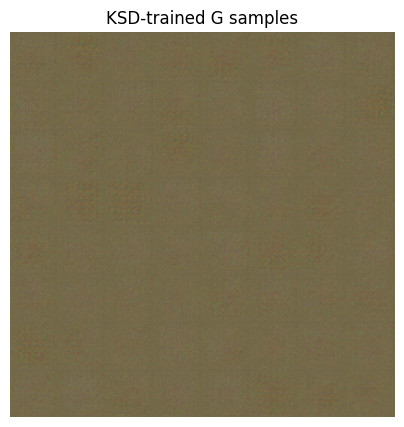

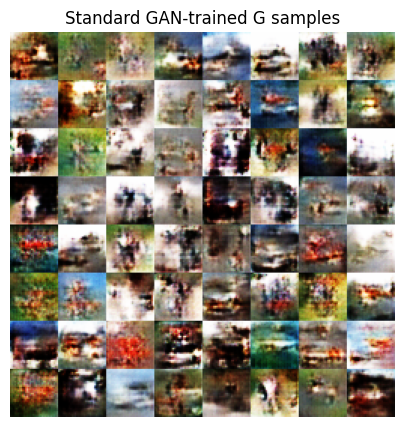

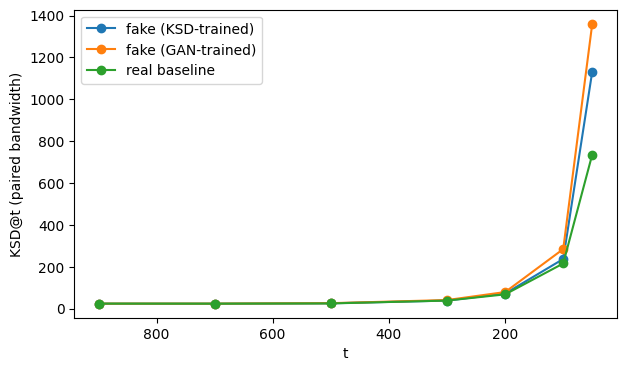

In [51]:
# 0) Keep a copy of your KSD-trained generator
G_ksd = copy.deepcopy(G).eval()

# 1) Train a standard GAN generator from scratch (same architecture)
G0 = DCGANGen(z_dim=128).to(device)  # fresh init for fair baseline
G_gan, D_gan, lossesG, lossesD = train_standard_gan(
    G_init=G0,
    loader=loader,
    steps=2000,            # start with 2k–5k; increase if stable
    batch_size=64,
    z_dim=128,
    log_every=200
)

show_samples(G_ksd, title="KSD-trained G samples")
show_samples(G_gan, title="Standard GAN-trained G samples")

# 2) Evaluate both with KSD@t
MC_SAMPLES = 8
RIDGE_LAM  = 1e-2

# IMPORTANT: don't go too low t initially (that’s where you saw explosions)
t_list = [int(x*(T-1)) for x in [0.9, 0.7, 0.5, 0.3, 0.2, 0.1, 0.05]]

real_vals_ksdG, fake_vals_ksdG = eval_ksd_over_t_paired(G_ksd, loader, ksd, t_list, ridge=1e-2)
real_vals_ganG, fake_vals_ganG = eval_ksd_over_t_paired(G_gan, loader, ksd, t_list, ridge=1e-2)

plt.figure(figsize=(7,4))
plt.plot(t_list, fake_vals_ksdG, marker="o", label="fake (KSD-trained)")
plt.plot(t_list, fake_vals_ganG, marker="o", label="fake (GAN-trained)")
plt.plot(t_list, real_vals_ksdG, marker="o", label="real baseline")
plt.gca().invert_xaxis()
plt.xlabel("t")
plt.ylabel("KSD@t (paired bandwidth)")
plt.legend()
plt.show()

